# Short read barcode extraction and analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os

sns.set_style('darkgrid')
pioneer_colors = ['#FF8633', '#423759', '#314942', '#FFA632', '#F7F3ED']
sns.set_palette(sns.color_palette(pioneer_colors))

result_dir = "."

## Setup and load results

In [6]:
def list_files(samps, basename):
    files = {key:os.path.join(val, basename) for key,val in samps.items()}
    return {key:val for key,val in files.items() if os.path.exists(val)}

def load_barcode_counts(samps, use_corrected = True):
    if use_corrected:
        path = "barcodes_corrected.tsv"
    else:
        path = "barcode_counts.tsv"
    out = []
    for key,val in list_files(samps, path).items():
        x = pd.read_table(val, names = ['barcode', 'count'])
        x['sample'] = key
        out.append(x)
    return pd.concat(out)

def load_read_stats(samps, path):
    out = []
    for key,val in list_files(samps, path).items():
        x = pd.read_table(val)
        x['sample'] = key
        out.append(x)
    return pd.concat(out)

### Sample list

In [3]:
samps = [x for x in os.listdir(result_dir) if os.path.isdir(os.path.join(result_dir, x))]
samps = {x:os.path.join(result_dir, x) for x in samps}
print(f'Analyzing samples: {', '.join(samps)}')

Analyzing samples: m-C-00159-2


### Load results

In [8]:
barcode_counts = load_barcode_counts(samps, use_corrected=True)
read_stats = load_read_stats(samps, "read_stats.tsv")
barcode_stats = load_read_stats(samps, "barcode_stats.tsv")
barcode_filt_stats = load_read_stats(samps, "barcodes_filtered_stats.tsv")

In [14]:
bc_stats = barcode_stats[['sample', 'num_seqs']].rename(columns={'num_seqs': 'barcodes_extracted'}) 
bc_filt = barcode_filt_stats[['sample', 'num_seqs']].rename(columns={'num_seqs': 'barcodes_filtered'})
uniq_bc = barcode_counts.value_counts('sample').reset_index().rename(columns = {'count': 'num_uniq_bc'})

### Summary  

In [17]:

read_stats[['sample', 'num_seqs']] \
    .drop_duplicates() \
    .merge(bc_stats) \
    .merge(bc_filt) \
    .assign(pct_barcodes = lambda x: 100 * (x.barcodes_filtered / x.num_seqs)) \
    .merge(uniq_bc) \
    .rename(columns = {'sample': 'Sample', 
                       'num_seqs': 'Total reads', 
                       'pct_barcodes': 'Perecent with barcodes',
                       'barcodes_extracted': 'Barcodes extracted',
                       'barcodes_filtered': 'Barcodes passed size filters',
                       'num_uniq_bc': 'Unique barcodes'}) \
    .style.format(precision = 2, thousands = ",")

,Sample,Total reads,Barcodes extracted,Barcodes passed size filters,Perecent with barcodes,Unique barcodes
0,m-C-00159-2,"4,935,927","4,834,241","4,816,765",97.59,"3,727,999"


### Barcode counts

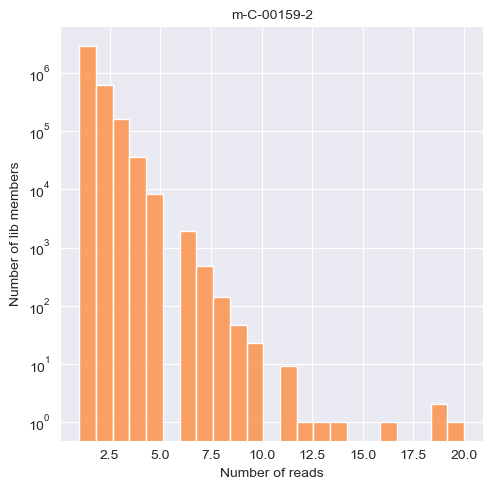

In [21]:
#fig, ax = plt.subplots(figsize=(10,7))
gr = sns.displot(barcode_counts, x = 'count', col = 'sample', col_order = samps)
gr.set_titles(col_template = '{col_name}')
gr.set(yscale='log')
gr.set_axis_labels('Number of reads', 'Number of lib members')